# Fake News Detection 

In [392]:
import urllib.request,sys,time
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

### The scrapper function 

The scrapper function will scrape 
> • Statement <br>
> • Link <br>
> • Date <br>
> • Source <br>
> • Label of news

In [376]:
def scrapper(n_pages): 
    
    Statement,Link,Date,Source,Label = [],[],[],[],[]
    results = []
    #executable_path = 'H:\Driver\chromedriver'
    #driver = webdriver.Chrome()
    

    for i in range(n_pages):
        url = 'https://www.politifact.com/factchecks/list/?page='+str(i)
        try:
            page=requests.get(url)                           
        except Exception as e:                                   
            error_type, error_obj, error_info = sys.exc_info()     
            print ('ERROR FOR LINK:',url)                          
            print (error_type, 'Line:', error_info.tb_lineno)     
            continue
        
        time.sleep(2)   
        soup=BeautifulSoup(page.text,'html.parser')
        frame=[]
        links=soup.find_all('li',attrs={'class':'o-listicle__item'})
        for j in links:
            Statement.append(j.find("div",attrs={'class':'m-statement__quote'}).text.strip())
            
            Link.append(j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip())
            Date.append(j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip())
            Source.append(j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip())
            Label.append(j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip())

    results = pd.DataFrame(list(zip(Statement,Link,Date,Source,Label)),
               columns =['Statement', 'Link','Date','Source','Label'])
    return results



Giving the number of pages to be scrapped

In [377]:
data = scrapper(50)

Filling empty cells i.e. NA values  with None

In [379]:
data = data.fillna('None')

Scrapping news articles for articles column in above dataframe

In [380]:
article = []
for i in data['Link']: 
    if i == 'None' :
        article.append('None')
    else:
        url = 'https://www.politifact.com' + i
        page=requests.get(url)                           
        soup = BeautifulSoup(page.content,'html.parser')
        n = soup.find(attrs={"class": "short-on-time", "p":""})
        #print(n)
        if n != None:
            n = n.get_text()
            m = " ".join(n.split())
            x = "".join(m.split("•"))
            y = x.strip()
            article.append(y)
        else :
            article.append('None')

Adding article column to the data frame with all the scrapped articles

In [396]:
print(len(article))
data['Article'] = article

1470


In [397]:
data.head()

,Statement,Link,Date,Source,Label,Article
0,“Kathy Barnette wants to build a statue of Bar...,/factchecks/2022/may/13/usa-freedom-fund/penns...,"May 13, 2022",USA Freedom Fund,mostly-true,Pennsylvania U.S. Senate candidate Kathy Barne...
1,Says the Biden administration is choosing to s...,/factchecks/2022/may/13/greg-abbott/providing-...,"May 13, 2022",Greg Abbott,barely-true,A 1997 legal settlement requires border offici...
2,Joe Biden “inherited inflation of 1.7%. Now we...,/factchecks/2022/may/13/kathy-barnette/kathy-b...,"May 13, 2022",Kathy Barnette,mostly-true,Barnette is right on the numbers. Inflation ha...
3,Homemade baby formula recipes offer a ‘viable ...,/factchecks/2022/may/13/facebook-posts/no-maki...,"May 13, 2022",Facebook posts,false,The U.S. Food and Drug Administration advises ...
4,“We’re one of the seven nations in the world t...,/factchecks/2022/may/13/lindsey-graham/fact-ch...,"May 13, 2022",Lindsey Graham,half-true,"Worldwide, a dozen nations, including the U.S...."


In [398]:
print(data.shape)

(1470, 6)


Saving dataframe to csv file

In [399]:
data.to_csv('data.csv')

Concatenating articles , source and statement of news and modifying labels to get ignore the least appearing news types and for better performance of model

false          800
pants-fire     228
barely-true    205
half-true      123
mostly-true     68
true            39
full-flop        4
half-flip        3
Name: Label, dtype: int64


<AxesSubplot:>

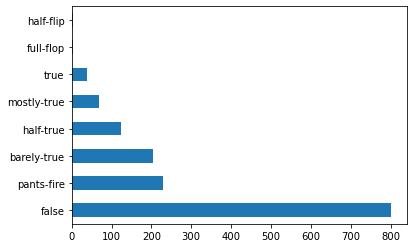

In [417]:
artricles_modified = data['Statement']+' '+ data['Article']+ data['Source']
labels = data['Label']
values = labels.value_counts()
labels_modified = labels.replace({'pants-fire':'false','barely-true':'true','half-true':'true','mostly-true':'true','full-flop':'false','half-flip':'false','no-flip':'true'})
#{'pants-fire':'false','barely-true':'true','half-true':'true','mostly-true':'true','full-flop':'false','half-flip':'false','no-flip':'true'}
print(values)
labels.value_counts().plot(kind='barh')


### New value counts of labels

false    1035
true      435
Name: Label, dtype: int64


<AxesSubplot:>

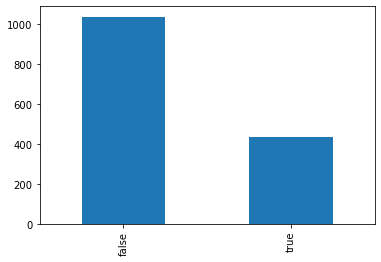

In [418]:
print(labels_modified.value_counts())

labels_modified.value_counts().plot(kind='bar')

### Value counts of top 10 labels

Facebook posts     479
Viral image        201
Instagram posts    110
Bloggers            67
Tweets              47
Joe Biden           35
TikTok posts        26
Donald Trump        15
Ron DeSantis        10
Glenn Youngkin       9
Name: Source, dtype: int64


<AxesSubplot:>

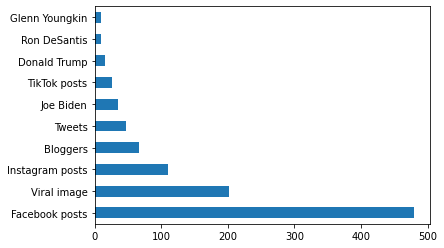

In [420]:
sources = data['Source']
print(sources.value_counts()[0:10])

sources.value_counts()[0:10].plot(kind='barh')

Stemming modified articles using porter stemmer

In [421]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [422]:
artricles_modified[0:5]

0    “Kathy Barnette wants to build a statue of Bar...
1    Says the Biden administration is choosing to s...
2    Joe Biden “inherited inflation of 1.7%. Now we...
3    Homemade baby formula recipes offer a ‘viable ...
4    “We’re one of the seven nations in the world t...
dtype: object

In [423]:
artricles_modified = artricles_modified.apply(stemming)

In [424]:
artricles_modified[0:5]

0    kathi barnett want build statu barack obama ri...
1    say biden administr choos send babi formula bo...
2    joe biden inherit inflat well grow barnett rig...
3    homemad babi formula recip offer viabl option ...
4    one seven nation world allow abort demand week...
dtype: object

Using grid search CV for finding best parameters for SVM model

In [425]:
def search_para(docs, y):
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn import svm
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf', svm.LinearSVC())])
    parameters = {'tfidf__use_idf':[True,False],'tfidf__binary':[True,False],'tfidf__min_df':[1,3,5,7],
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.5,1.0,2.0],}
    metric =  "f1_macro"
    gs_clf = GridSearchCV(text_clf, param_grid=parameters,scoring=metric, cv=5)
    gs_clf = gs_clf.fit(docs, y)
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,gs_clf.best_params_[param_name]))
    print("best f1 score: {:.2%}".format(gs_clf.best_score_))


In [426]:
search_para(artricles_modified, labels_modified)

clf__C:	0.5
tfidf__binary:	False
tfidf__min_df:	7
tfidf__stop_words:	english
tfidf__use_idf:	False
best f1 score: 70.91%


### Training the model with supervised learning algorithm linear SVM and doing performance evaluation 

In [427]:
def svm_model(artricles_modified, labels_modified,\
             dtm_options={'stop_words':None, 'min_df':1, 'use_idf':True, 'binary':'False'},
             svm_options = {'C':1}):
    
    import numpy as np
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn import svm
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve, auc,precision_recall_curve
    from matplotlib import pyplot as plt
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import train_test_split
    
    
    tfidf_vect = TfidfVectorizer(**dtm_options)
    dtm = tfidf_vect.fit_transform(artricles_modified) 
    X_train, X_test, Y_train, Y_test = train_test_split(\
                dtm, labels_modified, test_size=0.2, random_state=0)
       
    clf = svm.LinearSVC(**svm_options).fit(X_train, Y_train) 
    predicted = clf.predict(X_test)
    labels=sorted(Y_test.unique())    
    print(classification_report(Y_test, predicted, target_names=labels))
    predict_p=clf.decision_function(X_test) 
    print(predict_p.shape)

    binary_y = []
    binary_y = np.where(Y_test=='true',1,0)
    y_pred = predict_p
    fpr, tpr, thresholds = roc_curve(binary_y, y_pred,pos_label=1)
    precision, recall, thresholds = precision_recall_curve(binary_y,y_pred, pos_label=1)
    roc_auc = auc(fpr,tpr)
    prc_auc = auc(recall,precision)        
    print('AUC:\t{:.2%}\tPRC:\t{:.2%}'.format(roc_auc,prc_auc))
        
    plt.figure(); 
    #for i in range(len(labels)):
    plt.plot(fpr, tpr, lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC');
    
    
    
    plt.figure(); 
    #for i in range(len(labels)):
    plt.plot(recall, precision, lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Precision');
    plt.ylabel('Recall');
    plt.title('PRC');
    
    
    plt.subplots_adjust(wspace = 0.3)
    plt.show();
    
    return labels,dtm
    

              precision    recall  f1-score   support

       false       0.81      0.90      0.85       210
        true       0.66      0.48      0.55        84

    accuracy                           0.78       294
   macro avg       0.73      0.69      0.70       294
weighted avg       0.77      0.78      0.77       294

(294,)
AUC:	83.37%	PRC:	64.63%


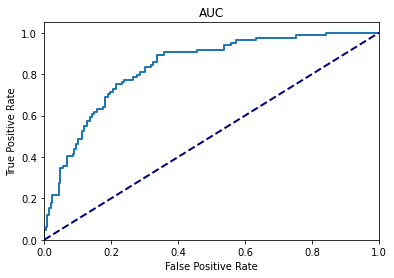

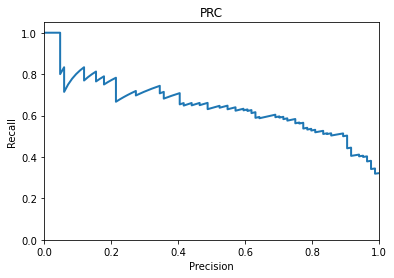

In [428]:
dtm_options={'stop_words':'english', 'min_df':1, 'use_idf':True, 'binary':True}
svm_options = {'C':0.5}
model, tfidf_vect = svm_model(artricles_modified, labels_modified,dtm_options = dtm_options,svm_options = svm_options)

### Training the model with supervised learning algorithm ,naive_bayes and doing performance evaluation by using the suitable parametrs

In [429]:
def Naive_Bayes(train_docs, train_y, dtm_options={'stop_words':None, 'min_df':1, 'use_idf':True, 'binary':'False'}):
    import numpy as np
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve, auc,precision_recall_curve
    from matplotlib import pyplot as plt
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import precision_recall_fscore_support
    
    
    tfidf_vect = TfidfVectorizer(**dtm_options)
    dtm = tfidf_vect.fit_transform(artricles_modified) 
    X_train, X_test, Y_train, Y_test = train_test_split(\
                dtm, labels_modified, test_size=0.2, random_state=0)
    labels=sorted(train_y.unique())
    #print(labels)
    #print(Y_test[0:10])
    clf = MultinomialNB().fit(X_train, Y_train)
    predicted = clf.predict(X_test)
    #print(predicted[0:10])

    predict_p=clf.predict_proba(X_test) 
    #print(predict_p[0:10])   
    
    precision, recall, fscore, support=\
    precision_recall_fscore_support(\
    Y_test, predicted, labels=labels)
    
    print(classification_report\
      (Y_test, predicted, target_names=labels))
    
    binary_y = np.where(Y_test=="true",1,0)
    y_pred = predict_p[:,1]
    fpr, tpr, thresholds = roc_curve(binary_y, y_pred, \
                                 pos_label=1)
    print("AUC: {:.2%}".format(auc(fpr, tpr)))
    
    from matplotlib import pyplot as plt
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    plt.show();
    
    precision, recall, thresholds = precision_recall_curve(binary_y, \
                                y_pred, pos_label=1)

    plt.figure();
    plt.plot(recall, precision, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    plt.show();

    # Calculate area under PRC curver (a.k.a average precision)
    # calculate auc
    print("Average Precision: {:.2%}".format(auc(recall, precision)))
    
    return labels,dtm
    

              precision    recall  f1-score   support

       false       0.79      0.94      0.86       210
        true       0.71      0.38      0.50        84

    accuracy                           0.78       294
   macro avg       0.75      0.66      0.68       294
weighted avg       0.77      0.78      0.75       294

AUC: 83.36%


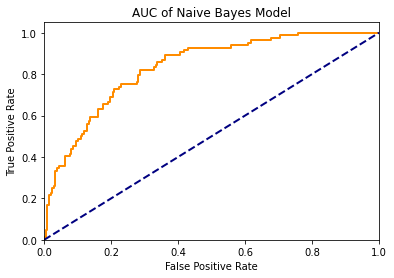

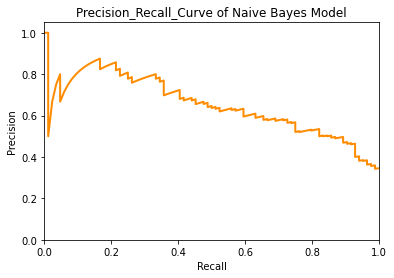

Average Precision: 64.90%


In [432]:
dtm_options={'stop_words':'english', 'min_df' : 5 ,'use_idf':True, 'binary':'False'}
model, tfidf_vect = Naive_Bayes(artricles_modified, labels_modified,dtm_options = dtm_options)